In [ ]:
%cd ..

In [2]:
# %% Import necessary libraries
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END, START

from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]
    route: str = None

# %% Setup LLM - Replace "llama3.3" with your desired model if needed
# Ensure Ollama server is running if using ChatOllama
temperature = 0.9
llm = ChatOllama(model="llama3.3", temperature=temperature)

# %% Define Placeholder Tools
# Normally, these would have real implementations and potentially Pydantic schemas for args
from tumkwe_invest.news import (
	tools as news_tools,
	TOOL_DESCRIPTION as NEWS_TOOL_DESCRIPTION,
)
from tumkwe_invest.sector import (
	tools as sector_tools,
	TOOL_DESCRIPTION as SECTOR_TOOL_DESCRIPTION,
)
from tumkwe_invest.ticker import (
	tools as ticker_tools,
	TOOL_DESCRIPTION as TICKER_TOOL_DESCRIPTION,
)

# from tumkwe_invest import tools as all_tools

In [3]:
# %% Create Specialized LLM Bindings
# Each LLM instance is bound only to the tools relevant for its role

llm_router = llm  # Router doesn't need tools bound for *this* simple routing logic
llm_news = llm.bind_tools(tools=news_tools)
llm_sector = llm.bind_tools(tools=sector_tools)
llm_ticker = llm.bind_tools(tools=ticker_tools)

In [4]:
llm_news

RunnableBinding(bound=ChatOllama(model='llama3.3', temperature=0.9), kwargs={'tools': [{'type': 'function', 'function': {'name': 'fetch_company_news', 'description': 'Fetch news articles about a specific company.\n\nArgs:\n    ticker: Stock ticker symbol or company name for search\n    max_articles: Maximum number of articles to retrieve\n\nReturns:\n    List news', 'parameters': {'properties': {'ticker': {'type': 'string'}, 'max_articles': {'default': 10, 'type': 'integer'}}, 'required': ['ticker'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [5]:
# %% Define Agent Nodes

# 1. Router Agent: Decides which specialist agent to call
ROUTER_PROMPT = """You are an expert request router. Your task is to analyze the user's latest query and determine which specialized agent is best suited to handle it.
The available agents are:
- 'news_agent': {NEWS_TOOL_DESCRIPTION}
- 'sector_agent': {SECTOR_TOOL_DESCRIPTION}
- 'ticker_agent': {TICKER_TOOL_DESCRIPTION}
- 'general_agent': Handles general conversation, greetings, or queries not fitting the other categories.

Based *only* on the user's last message, respond with *only* one of the following exact keywords: 'news', 'sector', 'ticker', or 'general'.

User Query:
{query}
"""

In [6]:
# Define system prompts for each agent
NEWS_SYSTEM_PROMPT = """You are a news analysis agent. Use your available tools to fetch and analyze news data when the user asks for recent events, headlines, or news-related information. If no tool is needed, provide a concise, helpful response."""
SECTOR_SYSTEM_PROMPT = """You are a sector analysis agent. Use your tools to provide insights on industries or sectors when asked. Otherwise, respond with general knowledge."""
TICKER_SYSTEM_PROMPT = """You are a stock ticker agent. Use your tools to fetch data on specific stock tickers when mentioned. If no ticker is provided, ask for clarification."""


def route_request(state: MessagesState):
    messages = state["messages"]
    user_query = messages[-1].content
    # Use a dedicated prompt for routing
    router_messages = [
        HumanMessage(
            content=ROUTER_PROMPT.format(
                query=user_query,
                NEWS_TOOL_DESCRIPTION=NEWS_TOOL_DESCRIPTION.strip(),
                SECTOR_TOOL_DESCRIPTION=SECTOR_TOOL_DESCRIPTION.strip(),
                TICKER_TOOL_DESCRIPTION=TICKER_TOOL_DESCRIPTION.strip(),
            )
        ),
    ]
    print("--- Calling Router Agent ---")
    response = llm_router.invoke(router_messages)
    print(f"Router Decision: {response.content}")
    return {
        "messages": [], "route": response.content
    }  # The content itself is the routing decision


# 2. Specialized Agent Nodes: Handle tasks for their category
def call_news_agent(state: MessagesState):
    messages = state["messages"]
    # Filter messages or add context if needed
    print("--- Calling News Agent ---")
    response = llm_news.invoke(messages)
    return {"messages": [response]}


def call_sector_agent(state: MessagesState):
    messages = state["messages"]
    print("--- Calling Sector Agent ---")
    response = llm_sector.invoke(messages)
    return {"messages": [response]}


def call_ticker_agent(state: MessagesState):
    messages = state["messages"]
    print("--- Calling Ticker Agent ---")
    response = llm_ticker.invoke(messages)
    return {"messages": [response]}


def call_general_agent(state: MessagesState):
    messages = state["messages"]
    print("--- Calling General Agent ---")
    # This agent might not have tools, or different general tools
    response = llm.invoke(messages)  # Using the base LLM
    return {"messages": [response]}

In [7]:
# %% Define Tool Nodes
# Each ToolNode handles tools for its specific category
news_tool_node = ToolNode(news_tools)
sector_tool_node = ToolNode(sector_tools)
ticker_tool_node = ToolNode(ticker_tools)

# %% Define Conditional Edge Logic

# 1. Decide branch after router
def decide_next_node(state: MessagesState):
	route: str = state["route"]
	# Check the content of the last message (which is the router's decision)
	if route is not None:
		content = route.strip().lower()
		if "news" in content:
			return "news_agent"
		elif "sector" in content:
			return "sector_agent"
		elif "ticker" in content:
			return "ticker_agent"
		else:
			return "general_agent" # Default to general if no keyword match
	return END # Should not happen in this setup ideally

# 2. Decide if a specialist agent needs to call its tools
def route_tools(state: MessagesState) -> str:
	"""
	Use in the conditional_edge to route to the ToolNode if the last message
	has tool calls. Otherwise, route to the end.
	"""
	messages = state["messages"]
	last_message = messages[-1]
	if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
		# LangGraph needs the ToolMessage invocation to be associated with the AI message Tool Call ID
		# The ToolNode will handle appending the ToolMessage with the results automatically
		print(f"--- Routing to Tools: {last_message.tool_calls[0]['name']} ---")
		return "call_tools" # A generic name for the routing decision
	print("--- No Tool Call Detected by Agent ---")
	return END

In [8]:
# %% Build the Graph
workflow = StateGraph(MessagesState)

# Add Nodes
workflow.add_node("router", route_request)
workflow.add_node("news_agent", call_news_agent)
workflow.add_node("news_tools", news_tool_node)
workflow.add_node("sector_agent", call_sector_agent)
workflow.add_node("sector_tools", sector_tool_node)
workflow.add_node("ticker_agent", call_ticker_agent)
workflow.add_node("ticker_tools", ticker_tool_node)
workflow.add_node("general_agent", call_general_agent) # Handles non-tool queries

# Define Entry Point
workflow.add_edge(START, "router")

# Conditional routing from the main router
workflow.add_conditional_edges(
	"router",
	decide_next_node,
	{
		"news_agent": "news_agent",
		"sector_agent": "sector_agent",
		"ticker_agent": "ticker_agent",
		"general_agent": "general_agent",
		END: END
	}
)

# Connections for the News branch
workflow.add_conditional_edges(
	"news_agent",
	route_tools, # Checks if the news_agent decided to call a tool
	{
		"call_tools": "news_tools", # If yes, go to news_tools node
		END: END                   # If no, end the flow
	}
)
workflow.add_edge("news_tools", "news_agent") # Results go back to the agent

# Connections for the Sector branch
workflow.add_conditional_edges(
	"sector_agent",
	route_tools,
	{
		"call_tools": "sector_tools",
		END: END
	}
)
workflow.add_edge("sector_tools", "sector_agent")

# Connections for the Ticker branch
workflow.add_conditional_edges(
	"ticker_agent",
	route_tools,
	{
		"call_tools": "ticker_tools",
		END: END
	}
)
workflow.add_edge("ticker_tools", "ticker_agent")

# General Agent branch (assuming no tools for this example, it just ends)
workflow.add_edge("general_agent", END)

# Compile the graph with memory
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

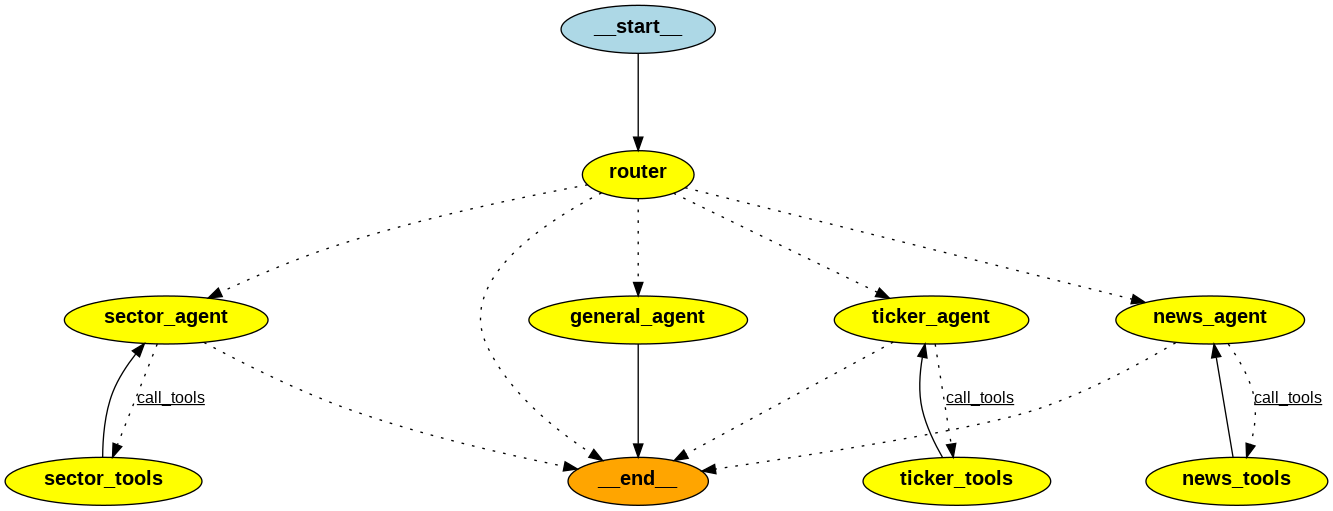

In [9]:
# %% Visualize the Graph (Optional)
try:
	img_data = graph.get_graph().draw_png()
	display(Image(img_data))
except Exception as e:
	# This requires some extra dependencies (like graphviz) and is optional
	print(f"Graph visualization failed (requires graphviz): {e}")
	pass

In [ ]:
# %% Interaction Loop
config = {"configurable": {"thread_id": "user-thread-1"}} # Use a unique ID for conversation history

def stream_graph_updates(user_input: str, config: dict):
	"""Helper function to stream graph events and print messages."""
	try:
		# The input is a list of messages, which is the format MessagesState expects
		inputs = {"messages": [HumanMessage(content=user_input)]}
		for event in graph.stream(inputs, config, stream_mode="values"):
			# The 'messages' key holds the list of messages in the state
			if "messages" in event:
				last_message: AIMessage = event["messages"][-1]
				last_message.pretty_print() # Pretty print the last message

	except Exception as e:
		print(f"\nAn error occurred during graph execution: {e}")
		# Consider adding more robust error handling or logging here

In [ ]:
if __name__ == "__main__":
	print("Starting hierarchical chatbot. Type 'quit', 'exit', or 'q' to stop.")
	while True:
		try:
			user_input = input("User: ")
			if user_input.lower() in ["quit", "exit", "q"]:
				print("Goodbye!")
				break
			else:
				stream_graph_updates(user_input, config)
		except KeyboardInterrupt:
			print("\nInterrupted by user. Goodbye!")
			break
		except Exception as e:
			print(f"An unexpected error occurred in the input loop: {e}")
			break

	print("Exiting the chatbot.")

Starting hierarchical chatbot. Type 'quit', 'exit', or 'q' to stop.
================================ Human Message =================================

Apple recent news
--- Calling Router Agent ---
Router Decision: news
================================ Human Message =================================

Apple recent news
--- Calling News Agent ---
--- Routing to Tools: fetch_company_news ---
================================== Ai Message ==================================
Tool Calls:
  fetch_company_news (57d178b4-63da-4628-aebd-a8d27a95feef)
 Call ID: 57d178b4-63da-4628-aebd-a8d27a95feef
  Args:
    max_articles: 10
    ticker: Apple


2025-04-01 15:38:33.944 | WARNING  | tumkwe_invest.news:fetch_company_news:35 - No results found for Apple.


================================= Tool Message =================================
Name: fetch_company_news

[{"title": "Apple's Find My has finally launched in South Korea", "source": "Engadget", "providerPublishTime": "2025-04-01 15:14:37"}, {"title": "Apple and Google app stores host VPNs linked to sanctioned Chinese group", "source": "Financial Times", "providerPublishTime": "2025-04-01 13:00:37"}, {"title": "Apple Stock Nears Citi’s Worst-Case. It Remains a Buy Even After Siri Delay.", "source": "Barrons.com", "providerPublishTime": "2025-04-01 13:59:00"}, {"title": "Apple Stock vs. Tesla Stock: Billionaires Buy One and Sell the Other", "source": "Motley Fool", "providerPublishTime": "2025-04-01 08:02:00"}, {"title": "Apple Expands Apple Intelligence Features in New Regions, Languages", "source": "MT Newswires", "providerPublishTime": "2025-03-31 17:42:46"}, {"title": "4 Upcoming Apple Products Worth Your Money in 2025", "source": "GOBankingRates", "providerPublishTime": "2025-04-01